In [18]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
from tile_coding import IHT, tiles
from IPython.display import HTML
from gym.envs import toy_text
import matplotlib.pyplot as plt

### Extending FrozenLake-v0 8x8 for Reward Shaping  

In [2]:
class RewardShapedFrozenLakeEnv(toy_text.frozen_lake.FrozenLakeEnv):
    def __init__(self, **kwargs):
        super(RewardShapedFrozenLakeEnv, self).__init__(**kwargs)

        for state in range(self.nS):      # for all states
            for action in range(self.nA): # for all actions
                agent_transitions = []
                for (probability, next_state, _, is_terminal_state) in self.P[state][action]:
                    row = next_state // self.ncol
                    col = next_state - row * self.ncol
                    tile_type = self.desc[row, col]
                    if tile_type == b'H':
                        reward = -0.2
                    elif tile_type == b'G':
                        reward = 1.
                    else:
                        reward = 0.0001

                    agent_transitions.append((probability, next_state, reward, is_terminal_state))
                self.P[state][action] = agent_transitions

In [3]:
frozen_lake_env = RewardShapedFrozenLakeEnv(desc=None, map_name="8x8")

## Semi-Gradient Sarsa(0) for FrozenLake-v0 8x8

In [4]:
class FrozenLakeQEstimator():
    
    def __init__(self, step_size, state_space, action_space, num_tilings=8):
        self.step_size = step_size
        self.max_size = 4096
        self.num_tilings = num_tilings
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = step_size / num_tilings
        self.iht = IHT(self.max_size)
        self.weights = np.zeros(self.max_size)
        
            
    def featurize_state_action(self, state, action):        
        featurized = tiles(self.iht, self.num_tilings, [state], [action])
        return np.array(featurized)
    
    
    def update(self, state, action, target):
        features = self.featurize_state_action(state, action)
        estimation = np.sum(self.weights[features])
        delta = (target - estimation)
        self.weights[features] += self.alpha * delta
            
    def estimate_value(self, state, action):
        features = self.featurize_state_action(state, action)
        estimated_value = np.sum(self.weights[features])
        return estimated_value

    
    def get_greedy_action(self, state):
        values = []
        for action_item in self.action_space:
            state_value = self.estimate_value(state, action_item)
            values.append(state_value)
        
        values = np.array(values)
        action_index = np.argmax(np.random.random(values.shape) * (values==values.max()))
        return self.action_space[action_index]

    def get_epsilon_greedy_action(self, state, epsilon):
        random_value = np.random.random()
        if random_value < 1 - epsilon:
            return self.get_greedy_action(state)
        
        return np.random.choice(self.action_space)

In [5]:
def semi_gradient_sarsa0_(env, estimator, gamma, epsilon_vals, episode_count):

    epsilon = epsilon_vals[0]
    rewards = []

    for episode in range(episode_count):
        state = env.reset()
        action = estimator.get_epsilon_greedy_action(state, epsilon) # select an action

        episode_rewards = 0
        done = False

        while not done:
            next_state, reward, done, _ = env.step(action)
            
            if done:
                estimator.update(state, action, reward)
                
            else:
                next_action = estimator.get_epsilon_greedy_action(next_state, epsilon)        
                next_step_estimated_value = estimator.estimate_value(next_state, next_action)
                target = reward + gamma * next_step_estimated_value
                estimator.update(state, action, target)
                
                state = next_state
                action = next_action
                episode_rewards += reward      

        epsilon = max(epsilon * epsilon_vals[2], epsilon_vals[1]) # epsilon decaying 
        rewards.append(episode_rewards) # append rewards

        if episode % 100 == 0:
            print("Episode Count", episode)
            print("Average rewards every 100 episodes:", np.mean(rewards[-100:]))   

    weights = estimator.weights
    return rewards, weights 

In [9]:
epsilon_start = 0.1
epsilon_end = 0
epsilon_decay = 0.999
epsilon_vals = (epsilon_start, epsilon_end, epsilon_decay)
number_tiles = 8
step_size = 0.4

est = FrozenLakeQEstimator(step_size, frozen_lake_env.observation_space, [0, 1, 2, 3], number_tiles)

# Semi-Gradient SARSA(0)
episodic_rewards, weights = semi_gradient_sarsa0_(env = frozen_lake_env, 
                                                  estimator = est, 
                                                  gamma = 0.9999, 
                                                  epsilon_vals=epsilon_vals, 
                                                  episode_count=4000)

Episode Count 0
Average rewards every 100 episodes: 0.0014000000000000004
Episode Count 100
Average rewards every 100 episodes: 0.007646999999999998
Episode Count 200
Average rewards every 100 episodes: 0.010438999999999999
Episode Count 300
Average rewards every 100 episodes: 0.00855099999999999
Episode Count 400
Average rewards every 100 episodes: 0.011044999999999982
Episode Count 500
Average rewards every 100 episodes: 0.012066999999999994
Episode Count 600
Average rewards every 100 episodes: 0.012735999999999987
Episode Count 700
Average rewards every 100 episodes: 0.014556999999999992
Episode Count 800
Average rewards every 100 episodes: 0.01424999999999999
Episode Count 900
Average rewards every 100 episodes: 0.014419999999999994
Episode Count 1000
Average rewards every 100 episodes: 0.01229599999999998
Episode Count 1100
Average rewards every 100 episodes: 0.013523999999999982
Episode Count 1200
Average rewards every 100 episodes: 0.02158499999999997
Episode Count 1300
Average 

In [10]:
print("Average episodic rewards over last 100 episodes:", np.mean(episodic_rewards[-100:]))

Average episodic rewards over last 100 episodes: 0.05108299999999779


In [35]:
def plot_values(episode_count, sarsa0_episode_rewards, title):
    plt.plot(np.arange(episode_count), sarsa0_episode_rewards[-episode_count:], label='SG sarsa(0) training')
    plt.ylim(0.001, 0)
    plt.xlim(0, episode_count)
    plt.xlabel('Number of Episodes')
    plt.ylabel('Total reward episode')
    plt.title(title)
    plt.legend()
    plt.show()

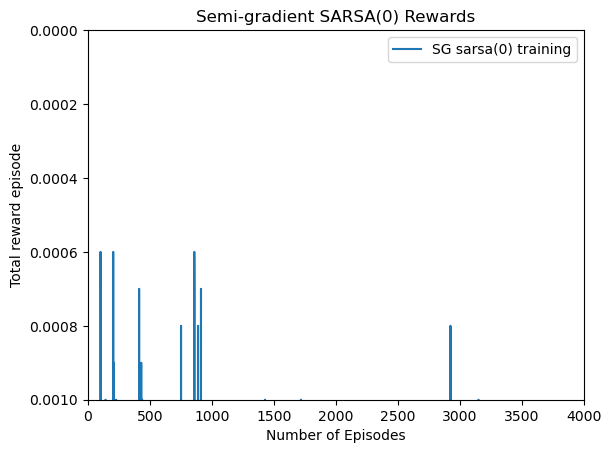



Episodic SG sarsa(0)
Average reward per episode every 100 episodes: 0.05108299999999779


In [36]:
plot_values(4000, episodic_rewards, 'Semi-gradient SARSA(0) Rewards')

print("")
print("\nEpisodic SG sarsa(0)")
print("Average reward per episode every 100 episodes:", np.mean(episodic_rewards[-100:]))

## Semi-Gradient TD $\large(\lambda)$

In [11]:
class FrozenLakeStateValueEstimator():

    def __init__(self, step_size, state_space, num_tilings=8):
        self.step_size = step_size
        self.max_size = 4096
        self.num_tilings = num_tilings
        self.state_space = state_space
        self.alpha = step_size / num_tilings
        self.iht = IHT(self.max_size)
        self.weights = np.zeros(self.max_size)
        self.eligibility_traces = np.zeros(self.max_size)
        
            
    def featurize_state(self, state):        
        featurized = tiles(self.iht, self.num_tilings, [state])
        return np.array(featurized)
    
    
    def update(self, state, target):
        features = self.featurize_state(state)
        estimation = np.sum(self.weights[features])
        delta = (target - estimation)
        self.eligibility_traces[features] = 1
        self.weights[features] += self.alpha * delta * self.eligibility_traces[features]
            
    def estimate_value(self, state):
        features = self.featurize_state(state)
        estimated_value = np.sum(self.weights[features])
        return estimated_value
    
    def reset_eligibility_traces(self):       
        self.eligibility_traces = np.zeros(self.max_size)

In [12]:
def semi_gradient_tdlambda_(env, estimator, gamma, epsilon_vals, episode_count, policy):

    epsilon = epsilon_vals[0]
    rewards = []

    for episode in range(episode_count):

        state = env.reset()
        action = policy.get_greedy_action(state) 
        
        estimator.reset_eligibility_traces()
        episode_rewards = 0
        done = False

        while not done:

            next_state, reward, done, _ = env.step(action)

            if done:
                estimator.update(state, reward)
            
            else:
                next_action = policy.get_greedy_action(next_state)        
                next_step_estimated_value = estimator.estimate_value(next_state)
                target = reward + gamma * next_step_estimated_value
                estimator.update(state, target)

                state = next_state
                action = next_action
                episode_rewards += reward      

        epsilon = max(epsilon * epsilon_vals[2], epsilon_vals[1]) # decay the epsilon

        rewards.append(episode_rewards)
        
        if episode % 100 == 0:
            print("Episode Count", episode)
            print("Average rewards every 100 episodes:", np.mean(rewards[-100:]))

    weights = estimator.weights
    return rewards, weights

In [13]:
class Generate_Policy():
    def __init__(self):
        self.action_space = [0, 1, 2, 3]

    def get_greedy_action(self, state, epsilon=0):
        action = np.random.choice(self.action_space)
        return action

In [14]:
tdlambda_step_size = 0.5
state_value_estimator = FrozenLakeStateValueEstimator(tdlambda_step_size, frozen_lake_env.observation_space)

# Semi-Gradient TD(lambda)
sg_tdlambda_rewards, sg_tdlambda_weights = semi_gradient_tdlambda_(
                                                env = frozen_lake_env, 
                                                estimator = state_value_estimator,
                                                gamma = 0.9999,
                                                epsilon_vals = epsilon_vals,                                               
                                                episode_count = 4000,
                                                policy = Generate_Policy())

Episode Count 0
Average rewards every 100 episodes: 0.0024999999999999996
Episode Count 100
Average rewards every 100 episodes: 0.003206999999999999
Episode Count 200
Average rewards every 100 episodes: 0.0031810000000000007
Episode Count 300
Average rewards every 100 episodes: 0.002952
Episode Count 400
Average rewards every 100 episodes: 0.0034889999999999995
Episode Count 500
Average rewards every 100 episodes: 0.0030399999999999993
Episode Count 600
Average rewards every 100 episodes: 0.003041
Episode Count 700
Average rewards every 100 episodes: 0.0028799999999999993
Episode Count 800
Average rewards every 100 episodes: 0.0032679999999999996
Episode Count 900
Average rewards every 100 episodes: 0.002748000000000001
Episode Count 1000
Average rewards every 100 episodes: 0.002763
Episode Count 1100
Average rewards every 100 episodes: 0.003080000000000001
Episode Count 1200
Average rewards every 100 episodes: 0.0028049999999999998
Episode Count 1300
Average rewards every 100 episodes

In [15]:
print("\nEpisodic semi-gradient TD(lambda) evaluating random policy")
print("Average reward per episode over", 100, "episodes:", np.mean(sg_tdlambda_rewards[-100:]))


Episodic semi-gradient TD(lambda) evaluating random policy
Average reward per episode over 100 episodes: 0.002955999999999999


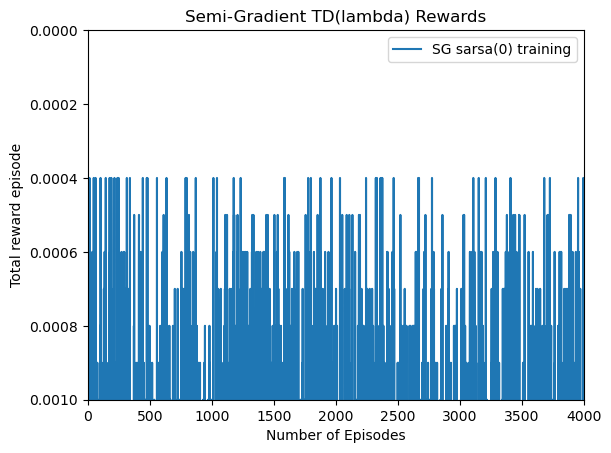



Semi-Gradient TD(lambda)
Average reward per episode every 100 episodes: 0.002955999999999999


In [37]:
plot_values(4000, sg_tdlambda_rewards, 'Semi-Gradient TD(lambda) Rewards')

print("")
print("\nSemi-Gradient TD(lambda)")
print("Average reward per episode every 100 episodes:", np.mean(sg_tdlambda_rewards[-100:]))